In [1]:
import rasterio
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import datetime
import glob as glob
import datetime
import sys
import os
import geopandas as gp
import warnings
warnings.filterwarnings("ignore")
# import seaborn as sns
%matplotlib inline

## Rainfall dataset

We use the rainfall dataset produced by Levy et al. (2017):  

Levy, M. C. (2017). Curated rain and flow data for the Brazilian rainforest-savanna transition zone, HydroShare, http://www.hydroshare.org/resource/e82e66572b444fc5b6bf16f88f911f77

The data is interpolated using each day's active rain gauge data. Interpolations were done on a 0.25° resolution grid; the IDW parameter was set to 2 (default). The maximum interpolation distance (radius) was 1000m. The dataset was then sampled at all 5000 datapoints in `./data/sesync2018_points.geojson`, which were randomly generated (avoiding 'artificial surfaces' using GlobCover 2009, a global land cover map available in Google Earth Engine) within the Amazon and Cerrado biomes (note: some points were discarded because the rainfall dataset does not entirely cover the extent of the Amazon and Cerrado biomes). 

In [2]:
df = pd.read_csv('./data/sesync2018_points_rainIdw.csv', parse_dates=True, index_col=0).resample('M').sum()

## Seasonality index

The seasonality index (S) is multi-year index taken from Feng et al 2013 (see literature folder). 

### Procedure

First, compute mean the monthly and annual rainfall for each site. Next, normalize monthly rainfall means by the annual mean to get a discrete probability mass function (pmf) representing the mean fraction of rainfall that falls in each month ($p_m$). Calculate the relative entropy of this pmf with respect to the uniform distribution (which has a probability mass of 1/12 for each month): $D = p_m \log_2 [\frac{p_m}{1/12} ]$. Finally, the seasonality index is the product of D and the ratio between the site’s mean annual rainfall and the maximum mean annual rainfall across all sites: $S_i = D \cdot \frac{\overline{R}}{\overline{R}_{max}}$. The seasonality index therefore represents both the extent to which rainfall is unevenly distributed throughout the year, as well as the magnitude of total rainfall at a site relative to the collection of sites. 

In [3]:
# with a dataframe of monthly rainfall totals for each site, 
# compute the seasonality index. 
# inputs: 
#     df: monthly time series dataframe of rainfall for all sites
#     maxmean: the maximum mean annual rainfall across all sites
# outputs:
#     A vector of seasonality indices for each site
def calc_S(df, maxmean):
    annualMeans = df.resample('A').sum().mean()
    pm = np.zeros((12, len(df.columns)))
    for g in df.groupby(df.index.month):
        month = g[0]
        pm[month-1, :] = g[1].mean()/annualMeans
    D = np.sum(pm*np.log2(pm/(1/12.0)), axis=0)
    return D*annualMeans/maxmean

# Compute seasonality indices across all sites for pre/post periods
# inputs: 
#     df: monthly time series dataframe of rainfall for all sites
#     pre: 2-tuple of start/stop years for the pre-treatment period
#     post: 2-tuple of start/stop years for the post-treatment period
# outputs:
#     Array where first row is a vector of seasonality indices for each site 
#     during pre-treatment, and the second row for post-treatment
def get_S(df, pre, post):
    dfpre = df.loc[pre[0]:pre[1]]
    dfpost = df.loc[post[0]:post[1]]
    maxmean = np.max([
        dfpre.resample('A').sum().mean().max(), 
        dfpost.resample('A').sum().mean().max()
    ])
    Spre = calc_S(dfpre, maxmean)
    Spost = calc_S(dfpost, maxmean)
    return np.vstack([Spre, Spost])

## Pre/post calculation of S

Define pre-treatment and post-treatment periods for the seasonality index. Get the seasonality index for each site in the pre and post periods. 

In [4]:
pre = ('1980', '1990')
post = ('2004', '2014')
S = calc_S(df, df.resample('A').sum().mean().max())
Ss = get_S(df, pre, post)

## Visualizing seasonality and changes in seasonality 

Text(0.5,1,'Changes in seasonality index ($\\mathrm{S_{post}} - \\mathrm{S_{pre}}$)')

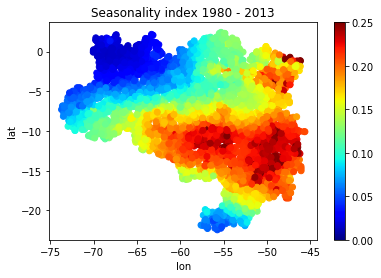

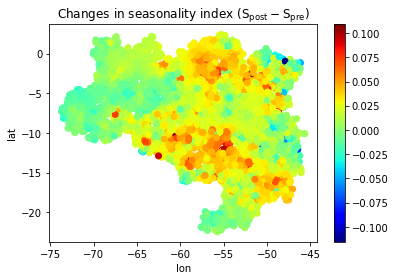

In [5]:
points = gp.read_file('./data/sesync2018_points.geojson').set_index('id')
points['ratio'] = np.nan
points['seasonality'] = np.nan
ids = [item for item in df.columns]
points.loc[ids, 'diff'] = Ss[1,:] - Ss[0,:]
points.loc[ids, 'seasonality'] = S

f,ax = plt.subplots(1)
points.plot('seasonality', ax=ax, legend=True, cmap='jet', vmax=.25, vmin=0)
ax.set_title('Seasonality index 1980 - 2013')
plt.ylabel('lat')
plt.xlabel('lon')
f,ax = plt.subplots(1)
points.plot('diff', ax=ax, legend=True, cmap='jet')
plt.ylabel('lat')
plt.xlabel('lon')
ax.set_title(r'Changes in seasonality index ($\mathrm{S_{post}} - \mathrm{S_{pre}}$)')

## Is there a significant shift in seasonality owing to the treatment? 

We will use a fixed-effects model to see if there is a change in the seasonality index between (arbitrarily chosen) control and treatment groups. This is a simple test that implicitly accounts for entity (site) and time fixed-effects. The coefficient on the `treatmentstatus` variable (call it $\tau$) measures the differential effect of the treatment on the metric ($y$; in this case, the seasonality index): 

$\tau = (\overline{y}_{treated, post} − \overline{y}_{treated, pre}) − (\overline{y}_{control, post} − \overline{y}_{control, pre})$

Because the treatment and control groups here are chosen completely at random, we do not expect to see any differences between the groups. 

In [8]:
np.shape(Ss)

(2, 3912)

In [7]:
test = pd.DataFrame.from_dict({0:Ss[0,:], 1:Ss[1,:]})
test['treated'] = np.random.randint(0,2,len(test))
test['id'] = df.columns
tofit = test.melt(value_vars = [0, 1], id_vars = ['treated', 'id'])
tofit['treatmentstatus'] = tofit.treated*tofit.variable
tofit = tofit.set_index(['id', 'variable'])

tofit

,,treated,value,treatmentstatus
id,variable,,,
1,0,0,0.179817,0
2,0,0,0.110728,0
4,0,0,0.169654,0
6,0,0,0.212847,0
7,0,1,0.222682,0
8,0,1,0.283417,0
9,0,0,0.205940,0
10,0,0,0.157360,0
11,0,0,0.232480,0


In [6]:
from linearmodels import PanelOLS
test = pd.DataFrame.from_dict({0:Ss[0,:], 1:Ss[1,:]})
test['treated'] = np.random.randint(0,2,len(test))
test['id'] = df.columns
tofit = test.melt(value_vars = [0, 1], id_vars = ['treated', 'id'])
tofit['treatmentstatus'] = tofit.treated*tofit.variable
tofit = tofit.set_index(['id', 'variable'])
res = PanelOLS(tofit.value, tofit.treatmentstatus, entity_effects=True, time_effects=True).fit()
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:                  value   R-squared:                        0.0005
Estimator:                   PanelOLS   R-squared (Between):              0.0025
No. Observations:                7824   R-squared (Within):               0.0222
Date:                Wed, Mar 07 2018   R-squared (Overall):              0.0026
Time:                        12:38:47   Log-likelihood                 2.459e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      1.8338
Entities:                        3912   P-value                           0.1758
Avg Obs:                       2.0000   Distribution:                  F(1,3910)
Min Obs:                       2.0000                                           
Max Obs:                       2.0000   F-statistic (robust):             1.8338
                            